# Tutorial de MostlyAI SDK — Práctico

Este notebook guía el primer bloque práctico del workshop. La charla introductoria cubrió teoría y contexto; aquí nos sumergimos directamente en el flujo de trabajo práctico que replicarás con el SDK de MostlyAI.

## Flujo de la Sesión

- Configuración del entorno

- Los fundamentos:
  - Cargar e inspeccionar el dataset de Titanic
  - Configurar y entrenar un generator de MostlyAI en modo local
  - Generar samples sintéticos y probar el generator
  - Producir un reporte de Quality Assurance (QA)
  - Ejecutar una prueba Train-on-Synthetic / Test-on-Real (TSTR)
  - ¿Alguna pregunta antes del coffee break?

- Usos de Synthetic Data:
  - Imputation
  - Rebalancing

- Synthetic Data preservando privacidad
- Synthetic Data justa

## 0. Configuración del Entorno

### Configuración Local

Esta sección te guía para configurar un entorno Python aislado para el tutorial. Usamos **uv**, una herramienta moderna que es mucho más rápida que `pip` + `venv` tradicional.

> **¿Por qué un entorno virtual?** Aísla las dependencias del proyecto para evitar conflictos con otras instalaciones de Python en tu sistema.

#### Paso 1: Instalar `uv`

**macOS / Linux:**
```bash
curl -LsSf https://astral.sh/uv/install.sh | sh
# Luego recarga tu shell o ejecuta:
export PATH="$HOME/.local/bin:$PATH"
```

**Windows (PowerShell):**
```powershell
iwr https://astral.sh/uv/install.ps1 -UseBasicParsing | iex
```

**Verificar instalación:**
```bash
uv --version
# Debería mostrar algo como: uv 0.x.x
```

#### Paso 2: Crear entorno virtual

```bash
# Navegar al directorio del proyecto (si no estás ya ahí)
cd /ruta/a/tu/proyecto

# Crear entorno virtual
uv venv .mostlyai-demo
```

#### Paso 3: Activar entorno virtual

**macOS / Linux:**
```bash
source .mostlyai-demo/bin/activate
```

**Windows (PowerShell):**
```powershell
.\.mostlyai-demo\Scripts\Activate.ps1
```

> **Indicador de éxito:** Deberías ver `(.mostlyai-demo)` al inicio de tu prompt de terminal.

#### Paso 4: Instalar dependencias

```bash
uv pip install -U "mostlyai[local]" jupyter ipykernel
```

> **¿Qué instala esto?**
> - `mostlyai[local]`: SDK de MostlyAI con todas las dependencias para modo local
> - `jupyter`: Para ejecutar notebooks
> - `ipykernel`: Para conectar el entorno con Jupyter

#### Paso 5: Registrar como kernel de Jupyter

```bash
python -m ipykernel install --user --name mostly-demo --display-name "Python (mostly-demo)"
```

> **¿Por qué esto?** Permite que Jupyter use este entorno específico en lugar del Python del sistema.

#### Paso 6: Ejecutar Jupyter Lab

```bash
uv run jupyter lab
```

> **Alternativa:** También puedes usar `jupyter lab` si ya tienes el entorno activado.

#### Verificación Final

1. **Jupyter Lab se abre** en tu navegador (generalmente en `http://localhost:8888`)
2. **Selecciona el kernel correcto:** En Jupyter, ve a **Kernel → Change Kernel → Python (mostly-demo)**
3. **Prueba la importación:** Ejecuta la primera celda de código del notebook

#### Comandos útiles

```bash
# Desactivar entorno (cuando termines)
deactivate

# Reactivar entorno (para futuras sesiones)
source .mostlyai-demo/bin/activate  # macOS/Linux
# o
.\.mostlyai-demo\Scripts\Activate.ps1  # Windows

# Eliminar entorno (si quieres empezar de nuevo)
rm -rf .mostlyai-demo  # macOS/Linux
# o
rmdir /s .mostlyai-demo  # Windows
```


### En Google Colab:

In [ ]:
!pip install -U "mostlyai[local]"

  Using cached gunicorn-23.0.0-py3-none-any.whl.metadata (4.4 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached schema-0.7.7-py2.py3-none-any.whl.metadata (34 kB)
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached python_multipart-0.0.20-py3-none-any.whl.metadata (1.8 kB)
  Using cached sshtunnel-0.4.0-py2.py3-none-any.whl.metadata (19 kB)
  Using cached pandas-2.2.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached psutil-5.9.8-cp38-abi3-macosx_11_0_arm64.whl.metadata (21 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 621.7/621.7 kB 7.4 MB/s  0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached idna-3.10-py3-no

## 1. Uso Básico: Generación de Datos y Evaluación de Calidad

En esta sección comenzaremos cargando el dataset de `Titanic`, que contiene los datos de pasajeros de uno de los naufragios más infames jamás conocidos.
Después de inspeccionar un poco el dataset, entrenaremos un generator usando el SDK de MOSTLYAI, generaremos algunos datos, y evaluaremos la calidad del dataset sintético comparando algunas estadísticas de datos y también estudiando su "usabilidad" para tareas de ML.

In [20]:
# Set random seed for reproducibility
import numpy as np
np.random.seed(42)  # 42, the answer to the ultimate question of life, the universe, and everything

In [21]:
# Import Python packages
import pandas as pd

# Initialize the SDK in local mode
from mostlyai.sdk import MostlyAI
mostly = MostlyAI(local=True)

Initializing Synthetic Data SDK 5.2.7 in LOCAL mode 🏠

Connected to ]8;id=536716;file:///Users/felipe/mostlyai\/Users/felipe/]8;;\]8;id=775059;file:///Users/felipe/mostlyai\mostlyai]8;;\ with 36 GB RAM, 14 CPUs, 0 GPUs available

In [22]:
# Download Titanic dataset
titanic_url = 'https://github.com/mostly-ai/public-demo-data/raw/refs/heads/dev/titanic/titanic.csv'
titanic = pd.read_csv(titanic_url)
print(titanic.shape)

(1309, 8)


In [23]:
# Preview Dataset
titanic.head()

survived  pclass     sex   age  sibsp  parch   fare embarked
0         1       1  female  29.0      0      0  211.0        S
1         1       1    male   1.0      1      2  152.0        S
2         0       1  female   2.0      1      2  152.0        S
3         0       1    male  30.0      1      2  152.0        S
4         0       1  female  25.0      1      2  152.0        S

### Descripción del Dataset de Titanic

- **`survived`** (0/1): Variable objetivo - indica si el pasajero sobrevivió (1) o no (0)
- **`pclass`** (1,2,3): Clase del ticket - 1ra clase (más lujosa), 2da clase, 3ra clase (más económica)
- **`sex`** (male/female): Género del pasajero
- **`age`** (años): Edad del pasajero (tiene valores faltantes)
- **`sibsp`** (0-8): Número de hermanos/cónyuges a bordo
- **`parch`** (0-9): Número de padres/hijos a bordo
- **`fare`** (libras): Precio del ticket pagado
- **`embarked`** (C/Q/S): Puerto de embarque - Cherbourg, Queenstown, Southampton

**Contexto histórico:**
- El Titanic se hundió en 1912 después de chocar con un iceberg
- Hubo diferencias significativas en las tasas de supervivencia según la clase social
- Las mujeres y niños tuvieron prioridad en los botes salvavidas
- Este dataset es famoso en machine learning por ser un ejemplo clásico de clasificación binaria


In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Configurar estilo de gráficos con matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Paleta de colores personalizada
colors = ['#2E8B57', '#4682B4', '#CD5C5C', '#FF69B4', '#4169E1', '#FFB6C1', '#87CEEB', '#98FB98', '#F0E68C', '#DDA0DD']


=== SUPERVIVENCIA POR CLASE SOCIAL ===
        Total_pasajeros  Sobrevivientes  Tasa_supervivencia
pclass                                                     
1                   323             200               0.619
2                   277             119               0.430
3                   709             181               0.255


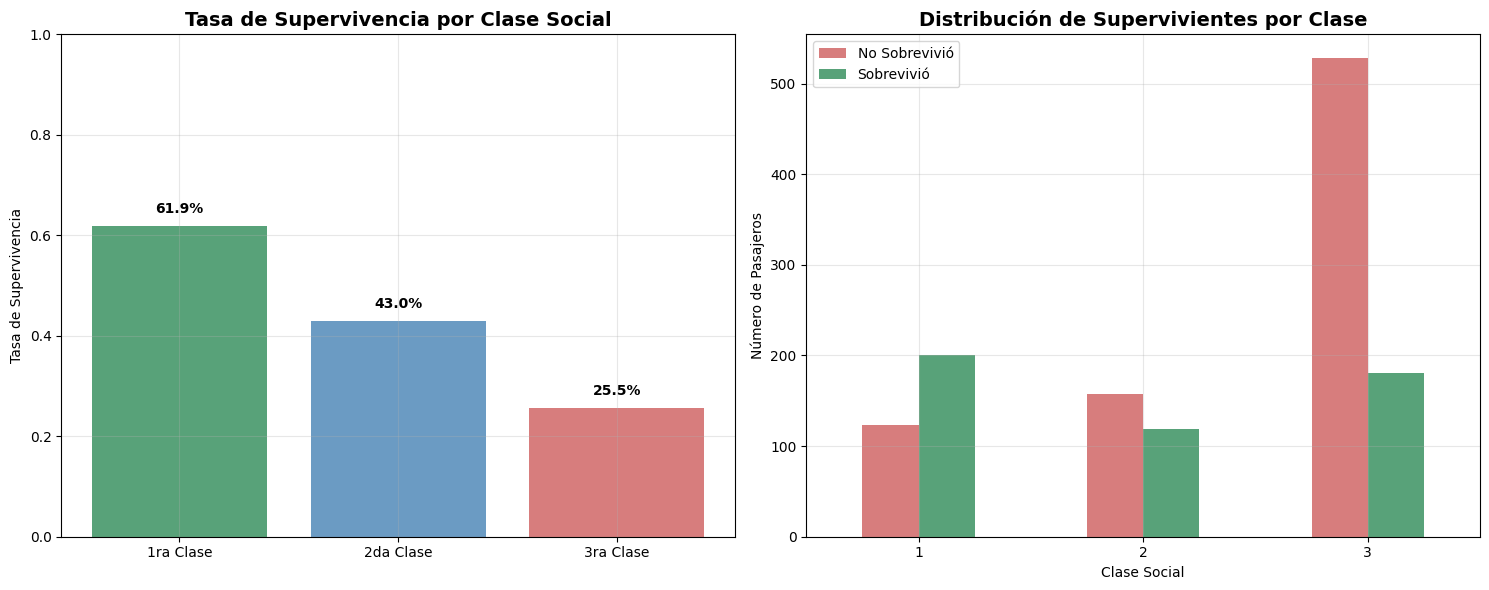


📊 CONCLUSIÓN: La 1ra clase tuvo 61.9% de supervivencia vs 25.5% en 3ra clase
   → ¡Las diferencias de clase social fueron dramáticas!


In [25]:
# 1. Verificar diferencias en supervivencia por clase social
print("=== SUPERVIVENCIA POR CLASE SOCIAL ===")
survival_by_class = titanic.groupby('pclass')['survived'].agg(['count', 'sum', 'mean']).round(3)
survival_by_class.columns = ['Total_pasajeros', 'Sobrevivientes', 'Tasa_supervivencia']
print(survival_by_class)

# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1: Tasa de supervivencia por clase
class_survival = titanic.groupby('pclass')['survived'].mean()
bars1 = ax1.bar(['1ra Clase', '2da Clase', '3ra Clase'], class_survival.values, 
               color=['#2E8B57', '#4682B4', '#CD5C5C'], alpha=0.8)
ax1.set_title('Tasa de Supervivencia por Clase Social', fontsize=14, fontweight='bold')
ax1.set_ylabel('Tasa de Supervivencia')
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for bar, value in zip(bars1, class_survival.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{value:.1%}', ha='center', va='bottom', fontweight='bold')

# Gráfico 2: Distribución de supervivientes vs no supervivientes por clase
survival_counts = titanic.groupby(['pclass', 'survived']).size().unstack()
survival_counts.plot(kind='bar', ax=ax2, color=['#CD5C5C', '#2E8B57'], alpha=0.8)
ax2.set_title('Distribución de Supervivientes por Clase', fontsize=14, fontweight='bold')
ax2.set_xlabel('Clase Social')
ax2.set_ylabel('Número de Pasajeros')
ax2.legend(['No Sobrevivió', 'Sobrevivió'])
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

print(f"\n📊 CONCLUSIÓN: La 1ra clase tuvo {class_survival[1]:.1%} de supervivencia vs {class_survival[3]:.1%} en 3ra clase")
print("   → ¡Las diferencias de clase social fueron dramáticas!")


=== SUPERVIVENCIA POR GÉNERO ===
        Total_pasajeros  Sobrevivientes  Tasa_supervivencia
sex                                                        
female              466             339               0.727
male                843             161               0.191

=== SUPERVIVENCIA DE NIÑOS (menores de 16 años) ===
        Total_niños  Sobrevivientes  Tasa_supervivencia
sex                                                    
female           56              37               0.661
male             59              29               0.492


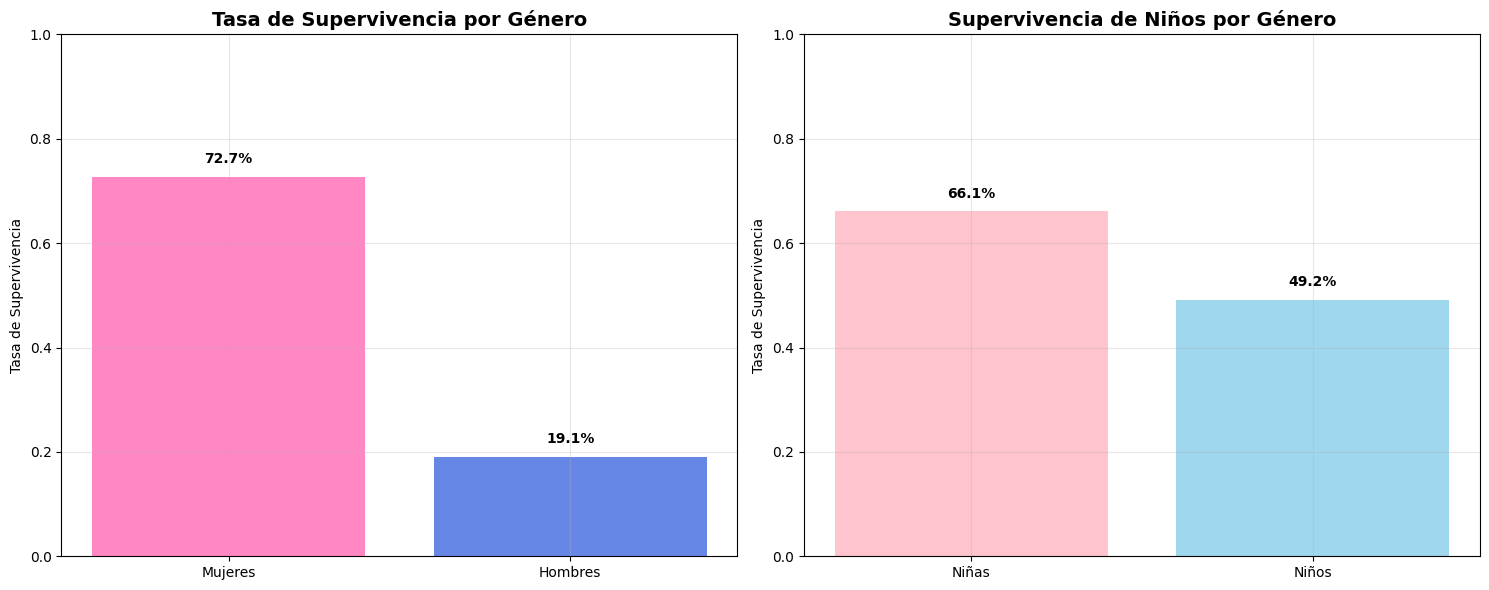


👩‍👧‍👦 CONCLUSIÓN: Las mujeres tuvieron 72.7% de supervivencia vs 19.1% en hombres
   → ¡La política de 'mujeres y niños primero' se reflejó en los datos!


In [26]:
# 2. Verificar la prioridad de mujeres y niños
print("=== SUPERVIVENCIA POR GÉNERO ===")
gender_survival = titanic.groupby('sex')['survived'].agg(['count', 'sum', 'mean']).round(3)
gender_survival.columns = ['Total_pasajeros', 'Sobrevivientes', 'Tasa_supervivencia']
print(gender_survival)

# Análisis de niños (menores de 16 años)
titanic['es_nino'] = titanic['age'] < 16
print("\n=== SUPERVIVENCIA DE NIÑOS (menores de 16 años) ===")
child_survival = titanic[titanic['es_nino']].groupby('sex')['survived'].agg(['count', 'sum', 'mean']).round(3)
child_survival.columns = ['Total_niños', 'Sobrevivientes', 'Tasa_supervivencia']
print(child_survival)

# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1: Supervivencia por género
gender_survival_rate = titanic.groupby('sex')['survived'].mean()
bars2 = ax1.bar(['Mujeres', 'Hombres'], gender_survival_rate.values, 
               color=['#FF69B4', '#4169E1'], alpha=0.8)
ax1.set_title('Tasa de Supervivencia por Género', fontsize=14, fontweight='bold')
ax1.set_ylabel('Tasa de Supervivencia')
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3)

for bar, value in zip(bars2, gender_survival_rate.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{value:.1%}', ha='center', va='bottom', fontweight='bold')

# Gráfico 2: Supervivencia de niños por género
child_survival_rate = titanic[titanic['es_nino']].groupby('sex')['survived'].mean()
if len(child_survival_rate) > 0:
    bars3 = ax2.bar(['Niñas', 'Niños'], child_survival_rate.values, 
                   color=['#FFB6C1', '#87CEEB'], alpha=0.8)
    ax2.set_title('Supervivencia de Niños por Género', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Tasa de Supervivencia')
    ax2.set_ylim(0, 1)
    ax2.grid(axis='y', alpha=0.3)
    
    for bar, value in zip(bars3, child_survival_rate.values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f'{value:.1%}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n👩‍👧‍👦 CONCLUSIÓN: Las mujeres tuvieron {gender_survival_rate['female']:.1%} de supervivencia vs {gender_survival_rate['male']:.1%} en hombres")
print("   → ¡La política de 'mujeres y niños primero' se reflejó en los datos!")


=== ANÁLISIS DE EDADES ===
Edad promedio de supervivientes: 28.9 años
Edad promedio de no supervivientes: 30.5 años

=== SUPERVIVENCIA POR GRUPO DE EDAD ===
                      Total  Sobrevivientes  Tasa_supervivencia
grupo_edad                                                     
Niño (0-12)              91              52               0.571
Adolescente (13-18)     102              41               0.402
Joven Adulto (19-35)    528             205               0.388
Adulto (36-60)          290             119               0.410
Mayor (60+)              32               8               0.250


/var/folders/1d/07tsgjy52_l231_vfjhmf00w0000gn/T/ipykernel_78923/3573243428.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_survival = titanic.groupby('grupo_edad')['survived'].agg(['count', 'sum', 'mean']).round(3)
/var/folders/1d/07tsgjy52_l231_vfjhmf00w0000gn/T/ipykernel_78923/3573243428.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_survival_rate = titanic.groupby('grupo_edad')['survived'].mean()


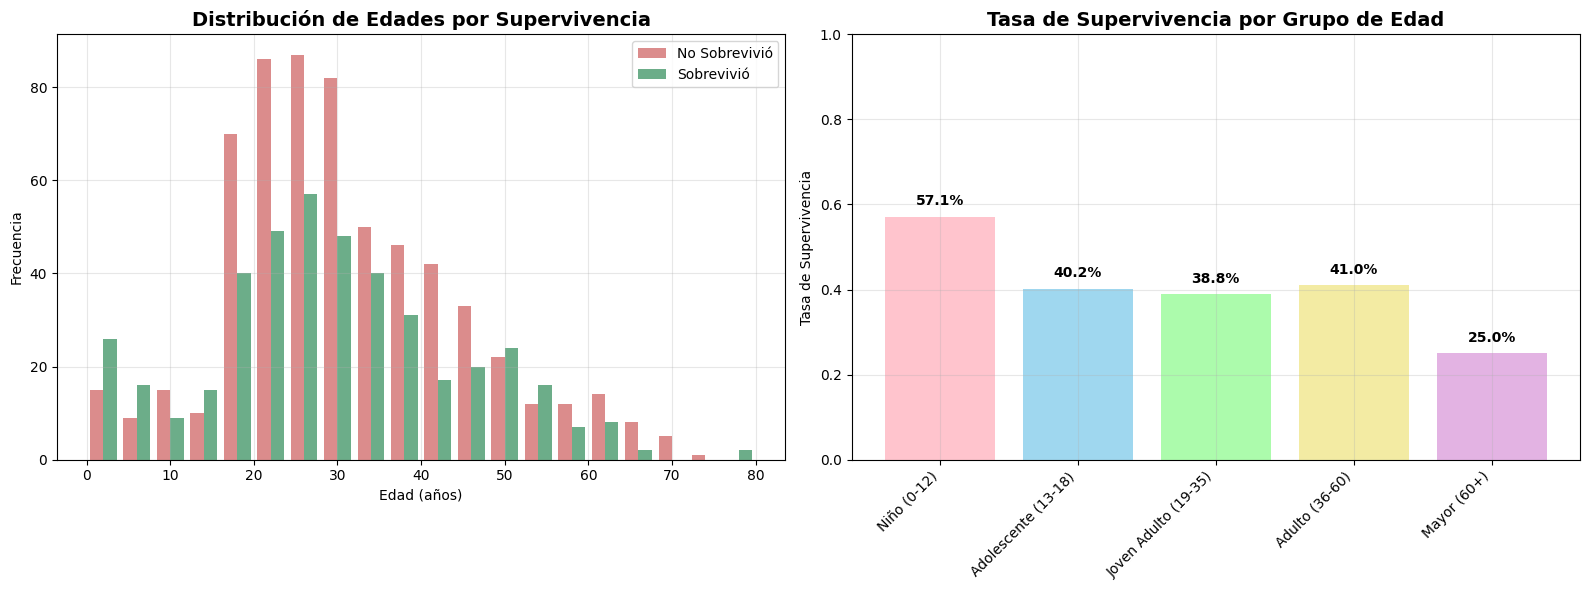


👶 CONCLUSIÓN: Los niños tuvieron las tasas de supervivencia más altas
   → ¡La política de 'mujeres y niños primero' fue efectiva!


In [27]:
# 3. Análisis de la distribución de edades y su impacto en supervivencia
print("=== ANÁLISIS DE EDADES ===")
print(f"Edad promedio de supervivientes: {titanic[titanic['survived']==1]['age'].mean():.1f} años")
print(f"Edad promedio de no supervivientes: {titanic[titanic['survived']==0]['age'].mean():.1f} años")

# Análisis por grupos de edad
titanic['grupo_edad'] = pd.cut(titanic['age'], bins=[0, 12, 18, 35, 60, 100], 
                              labels=['Niño (0-12)', 'Adolescente (13-18)', 'Joven Adulto (19-35)', 
                                     'Adulto (36-60)', 'Mayor (60+)'])

age_survival = titanic.groupby('grupo_edad')['survived'].agg(['count', 'sum', 'mean']).round(3)
age_survival.columns = ['Total', 'Sobrevivientes', 'Tasa_supervivencia']
print("\n=== SUPERVIVENCIA POR GRUPO DE EDAD ===")
print(age_survival)

# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Distribución de edades
ax1.hist([titanic[titanic['survived']==0]['age'].dropna(), 
          titanic[titanic['survived']==1]['age'].dropna()], 
         bins=20, alpha=0.7, label=['No Sobrevivió', 'Sobrevivió'], 
         color=['#CD5C5C', '#2E8B57'])
ax1.set_title('Distribución de Edades por Supervivencia', fontsize=14, fontweight='bold')
ax1.set_xlabel('Edad (años)')
ax1.set_ylabel('Frecuencia')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Gráfico 2: Tasa de supervivencia por grupo de edad
age_survival_rate = titanic.groupby('grupo_edad')['survived'].mean()
bars4 = ax2.bar(range(len(age_survival_rate)), age_survival_rate.values, 
               color=['#FFB6C1', '#87CEEB', '#98FB98', '#F0E68C', '#DDA0DD'], alpha=0.8)
ax2.set_title('Tasa de Supervivencia por Grupo de Edad', fontsize=14, fontweight='bold')
ax2.set_ylabel('Tasa de Supervivencia')
ax2.set_xticks(range(len(age_survival_rate)))
ax2.set_xticklabels(age_survival_rate.index, rotation=45, ha='right')
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)

for bar, value in zip(bars4, age_survival_rate.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{value:.1%}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n👶 CONCLUSIÓN: Los niños tuvieron las tasas de supervivencia más altas")
print("   → ¡La política de 'mujeres y niños primero' fue efectiva!")


In [ ]:
# 4. Resumen: ¿Por qué el Titanic es famoso en Machine Learning?
print("=== RESUMEN: ¿POR QUÉ EL TITANIC ES FAMOSO EN ML? ===")

# Estadísticas generales
total_passengers = len(titanic)
survivors = titanic['survived'].sum()
survival_rate = titanic['survived'].mean()

print(f"📊 DATOS GENERALES:")
print(f"   • Total de pasajeros: {total_passengers:,}")
print(f"   • Sobrevivientes: {survivors:,} ({survival_rate:.1%})")
print(f"   • No sobrevivientes: {total_passengers - survivors:,} ({1-survival_rate:.1%})")

# Características que lo hacen ideal para ML
print(f"\n🤖 CARACTERÍSTICAS IDEALES PARA MACHINE LEARNING:")
print(f"   ✅ Clasificación binaria clara (sobrevivió/no sobrevivió)")
print(f"   ✅ Variables categóricas y numéricas mezcladas")
print(f"   ✅ Valores faltantes (desafío de imputation)")
print(f"   ✅ Desbalance de clases ({survival_rate:.1%} vs {1-survival_rate:.1%})")
print(f"   ✅ Relaciones complejas entre variables")
print(f"   ✅ Contexto histórico conocido y verificable")

# Análisis de correlaciones
print(f"\n🔍 PATRONES IDENTIFICADOS:")
print(f"   • Clase social: 1ra clase ({titanic[titanic['pclass']==1]['survived'].mean():.1%}) vs 3ra clase ({titanic[titanic['pclass']==3]['survived'].mean():.1%})")
print(f"   • Género: Mujeres ({titanic[titanic['sex']=='female']['survived'].mean():.1%}) vs Hombres ({titanic[titanic['sex']=='male']['survived'].mean():.1%})")
print(f"   • Edad: Niños tuvieron mayor supervivencia")

# Visualización final: Heatmap de correlaciones
plt.figure(figsize=(10, 8))
correlation_data = titanic[['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare']].corr()

# Crear heatmap con matplotlib
im = plt.imshow(correlation_data, cmap='RdYlBu_r', aspect='auto')
plt.colorbar(im, shrink=0.8)

# Añadir valores de correlación
for i in range(len(correlation_data.columns)):
    for j in range(len(correlation_data.columns)):
        plt.text(j, i, f'{correlation_data.iloc[i, j]:.2f}', 
                ha='center', va='center', fontweight='bold')

# Configurar ejes
plt.xticks(range(len(correlation_data.columns)), correlation_data.columns, rotation=45)
plt.yticks(range(len(correlation_data.columns)), correlation_data.columns)

plt.title('Matriz de Correlaciones - Variables Numéricas', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n🎯 CONCLUSIÓN FINAL:")
print(f"   El dataset de Titanic es perfecto para aprender ML porque combina:")
print(f"   • Historia real y verificable")
print(f"   • Desafíos técnicos reales (valores faltantes, desbalance)")
print(f"   • Variables interpretables")
print(f"   • Resultados que se pueden validar históricamente")
print(f"   → ¡Por eso es el 'Hello World' de la clasificación binaria!")


In [5]:
titanic.describe().T.head(10)

count       mean        std  min   25%   50%   75%    max
survived  1309.0   0.381971   0.486055  0.0   0.0   0.0   1.0    1.0
pclass    1309.0   2.294882   0.837836  1.0   2.0   3.0   3.0    3.0
age       1046.0  29.870937  14.411571  0.0  21.0  28.0  39.0   80.0
sibsp     1309.0   0.498854   1.041658  0.0   0.0   0.0   1.0    8.0
parch     1309.0   0.385027   0.865560  0.0   0.0   0.0   0.0    9.0
fare      1308.0  33.311927  51.756793  0.0   8.0  14.0  31.0  512.0

El SDK divide automáticamente el training set dado para realizar early-stopping. Sin embargo, dividiremos el dataset con anticipación para poder validar más adelante algunas tareas downstream en un dataset de holdout.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_ho = train_test_split(titanic, test_size=0.2, random_state=42, stratify=titanic['survived'])

print(f"Training rows: {len(X_train):,}; Hold-out rows: {len(X_ho):,}")

Training rows: 1,047; Hold-out rows: 262


### Ahora entrenemos un generator

Comenzamos definiendo la configuración del generator. Aquí podemos elegir hyperparameters como el [tiempo máximo de entrenamiento](https://docs.mostly.ai/generators/configure/improve-model-accuracy), si queremos [fijar el orden de las columnas o no](https://docs.mostly.ai/generators/configure/enable-flexible-generation#set-flexible-generation), especificar el [tipo de encoding](https://docs.mostly.ai/generators/configure/set-encoding-types) de cada columna, etc.

In [ ]:
config={
        'name': 'Titanic',                       # name of the generator
        'tables': [{                             # provide list of table(s)
            'name': 'titanic',                   # name of the table
            'data': X_train,                     # the original data as pd.DataFrame
            'tabular_model_configuration': {     # tabular model configuration (optional)
                'max_training_time': 2,          # cap runtime for demo; set None for max accuracy
                # model, max_epochs,,..          # further model configurations (optional)
                # 'differential_privacy': {      # differential privacy configuration (optional)
                #     'max_epsilon': 5.0,        # - max epsilon value, used as stopping criterion
                #     'delta': 1e-5,             # - delta value
                # }
            },
        #     "columns": [
        #     {
        #        "name": "age",
        #        "model_encoding_type": "TABULAR_NUMERIC_DIGIT"
        #     },
        #     {
        #        "name": "fare",
        #        "model_encoding_type": "TABULAR_NUMERIC_DIGIT"
        #     },
        #     {
        #        "name": "pclass",
        #        "model_encoding_type": "TABULAR_CATEGORICAL"
        #     },
        #     {
        #        "name": "sex",
        #        "model_encoding_type": "TABULAR_CATEGORICAL"
        #     },
        #     {
        #        "name": "embarked",
        #        "model_encoding_type": "TABULAR_CATEGORICAL"
        #     },
        #     {
        #        "name": "sibsp",
        #        "model_encoding_type": "TABULAR_NUMERIC_DIGIT"
        #     },
        #     {
        #        "name": "parch",
        #        "model_encoding_type": "TABULAR_NUMERIC_DIGIT"
        #     },
        #     {
        #        "name": "survived",
        #        "model_encoding_type": "TABULAR_CATEGORICAL"
        #     }
        #  ]
            # keys, compute,..      # further table configurations (optional)
        }]
    }

In [ ]:
# Train a generator on the Titanic dataset
g = mostly.train(config=config)

Created generator db8fcf16-3896-41b7-a48f-3e7b526ab146

Started generator training

Output()

🎉 Your generator is ready! Use it to create synthetic data. Publish it so others can do the same.

### Probar y Generar Samples Sintéticos

Usa `mostly.probe` para verificaciones rápidas y `mostly.generate` para datasets completos.

In [ ]:
probe = mostly.probe(g, size=5)
display(probe)

survived  pclass     sex   age  sibsp  parch  fare embarked
0         1       3  female   6.0      1      2    77        S
1         0       3    male   9.0      0      0     8        S
2         1       1    male  16.0      0      0     8        S
3         1       2  female  45.0      0      0    20        S
4         1       3  female   NaN      0      0     0        S

In [ ]:
# Create a full synthetic dataset
syn_dataset = mostly.generate(g)
X_syn = syn_dataset.data()

Created synthetic dataset 49c0a7f4-0582-4315-8ef2-137cc53c1297 with generator db8fcf16-3896-41b7-a48f-3e7b526ab146

Started synthetic dataset generation

Output()

🎉 Your synthetic dataset is ready! Use it to consume the generated data. Publish it so others can do the same.

In [ ]:
X_syn.shape  # Same shape as our training set

(1047, 8)

In [ ]:
X_syn.head(5)

survived  pclass     sex   age  sibsp  parch  fare embarked
0         1       3  female     1      0      0    16        C
1         0       2    male    36      0      0   130        S
2         1       3    male  <NA>      0      0     1        S
3         1       1  female    28      0      0    29        S
4         0       3    male  <NA>      0      0     9        S

### ¿Qué tan bueno es este dataset sintético?

**Pregunta rápida:** ¿Cómo verificarías la bondad de ajuste de este modelo?

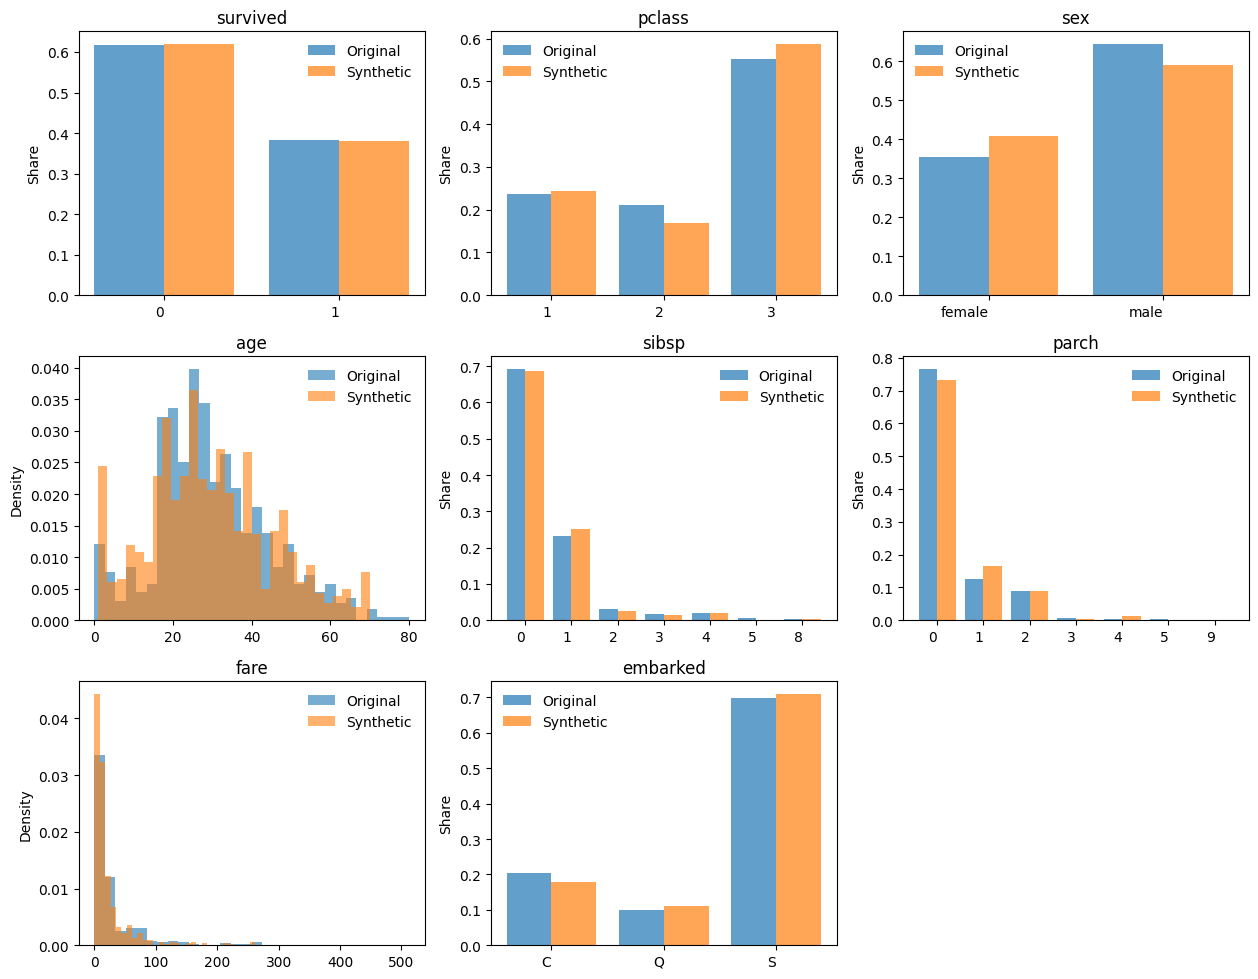

In [ ]:
# Not exhaustive but we could compare the univariate distributions of the original and synthetic data:

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def is_categorical(series, max_unique=8):
    if series.dtype.name == "category":
        return True
    if pd.api.types.is_bool_dtype(series) or pd.api.types.is_object_dtype(series):
        return True
    if pd.api.types.is_integer_dtype(series) and series.nunique(dropna=False) <= max_unique:
        return True
    if pd.api.types.is_float_dtype(series):
        unique = series.dropna().unique()
        if len(unique) <= max_unique and np.allclose(unique, unique.astype(int)):
            return True
    return False

cols = list(X_train.columns)
n_cols = 3
n_rows = math.ceil(len(cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.2, n_rows * 3.3))
axes = np.array(axes).ravel()

for ax in axes[len(cols):]:
    fig.delaxes(ax)

for idx, col in enumerate(cols):
    ax = axes[idx]
    orig = X_train[col]
    synth = X_syn[col]

    if is_categorical(orig):
        orig_counts = orig.fillna("Missing").astype(str).value_counts(normalize=True)
        synth_counts = synth.fillna("Missing").astype(str).value_counts(normalize=True)
        categories = sorted(set(orig_counts.index) | set(synth_counts.index))

        x = np.arange(len(categories))
        width = 0.4

        ax.bar(x - width / 2, [orig_counts.get(c, 0) for c in categories],
               width=width, alpha=0.7, color="#1f77b4", label="Original")
        ax.bar(x + width / 2, [synth_counts.get(c, 0) for c in categories],
               width=width, alpha=0.7, color="#ff7f0e", label="Synthetic")

        ax.set_xticks(x)
        ax.set_xticklabels(categories, rotation=0, ha="right")
        ax.set_ylabel("Share")
    else:
        combined = pd.concat([orig, synth], ignore_index=True).dropna()
        bins = min(30, max(10, int(np.sqrt(len(combined)))))

        ax.hist(orig.dropna(), bins=bins, alpha=0.6, density=True,
                label="Original", color="#1f77b4")
        ax.hist(synth.dropna(), bins=bins, alpha=0.6, density=True,
                label="Synthetic", color="#ff7f0e")
        ax.set_ylabel("Density")

    ax.set_title(col)
    ax.legend(frameon=False)

plt.tight_layout()
plt.show()


### Una evaluación de calidad más exhaustiva

El reporte de **Quality Assurance** (QA) organiza las métricas de calidad alrededor de dos conceptos: fidelidad y novedad. La fidelidad nos dice qué tan bien el modelo capturó la distribución de los datos originales. Al mismo tiempo queremos asegurarnos de que no estamos simplemente copiando y pegando ingenuamente el dataset original; esto es lo que cuantifican las métricas de novedad.

Más específicamente, el reporte presenta métricas de **accuracy**, **similarity** y **distance**. Profundicemos un poco en cada una de estas.

1. Las métricas de **Accuracy** comparan distribuciones marginales de bajo orden reales y sintéticas, en particular, distribuciones univariadas y bivariadas:
      - Univariate accuracy compara distribuciones univariadas discretizadas
      - Bivariate accuracy compara la distribución de pares de features mediante tablas de contingencia bivariadas discretizadas
  
2. Podría suceder que capturemos marginales de bajo orden pero aún fallemos en modelar adecuadamente la distribución conjunta completa. Calculamos un score de **similarity** basado en la similitud de coseno de embeddings de registros para inspeccionar cómo coinciden las distribuciones de orden superior:
   - cada registro se transforma en un string
   - cada string-registro se alimenta a un language model pre-entrenado para obtener embeddings
   - calculamos centroides para los datasets de training y sintéticos
   - computamos la similitud de coseno entre centroides
   
3. Mientras que las dos métricas anteriores evalúan la fidelidad del generator, las métricas de **distance** informan sobre la capacidad del modelo para generar datasets sintéticos novedosos. Usando los embeddings calculados en (2), computamos la Distance to the Closest Record (DCR) de cada registro sintético contra samples de training y samples de hold-out. Si nuestro modelo es bueno, entonces el dataset sintético estará "igualmente distante" del training set y del hold-out set. 


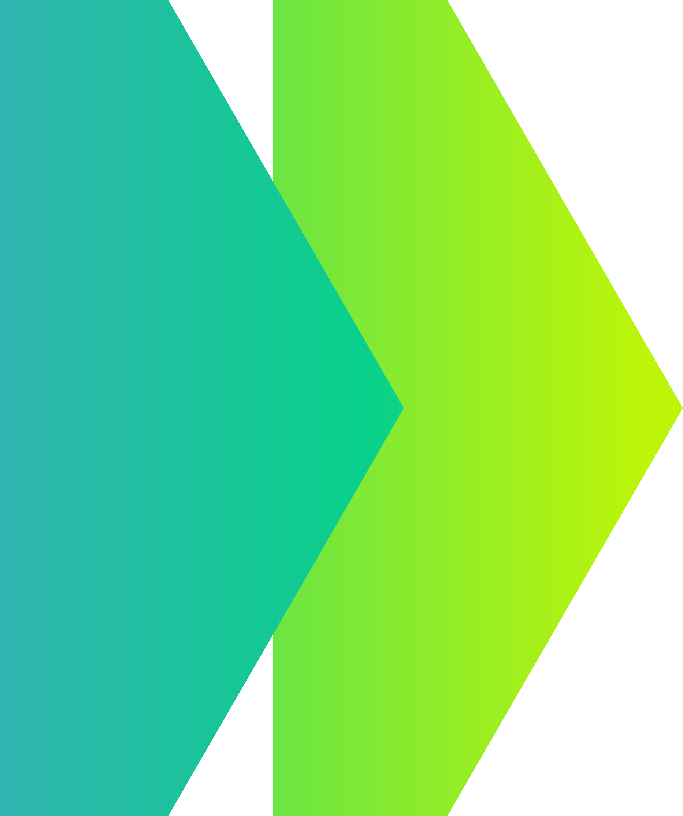
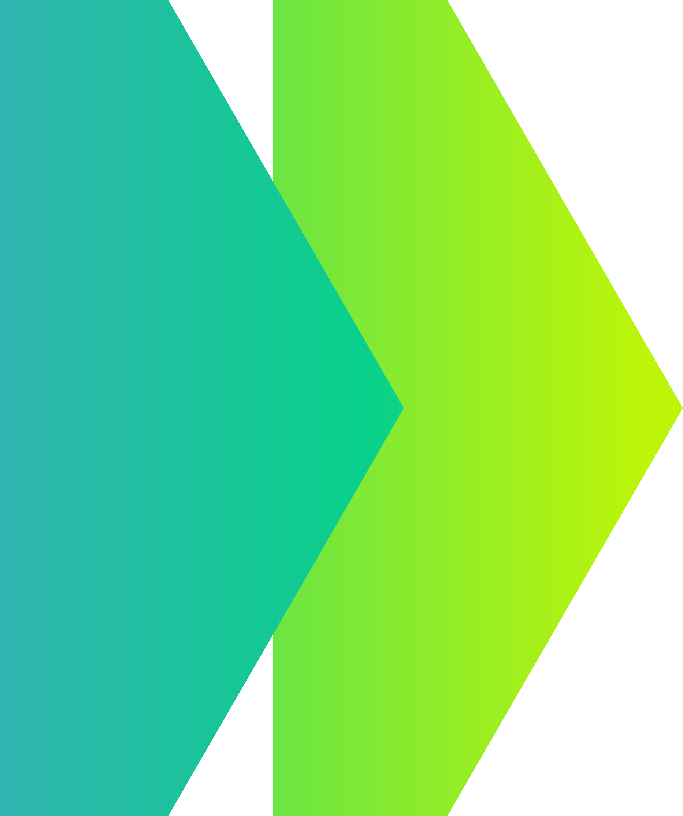
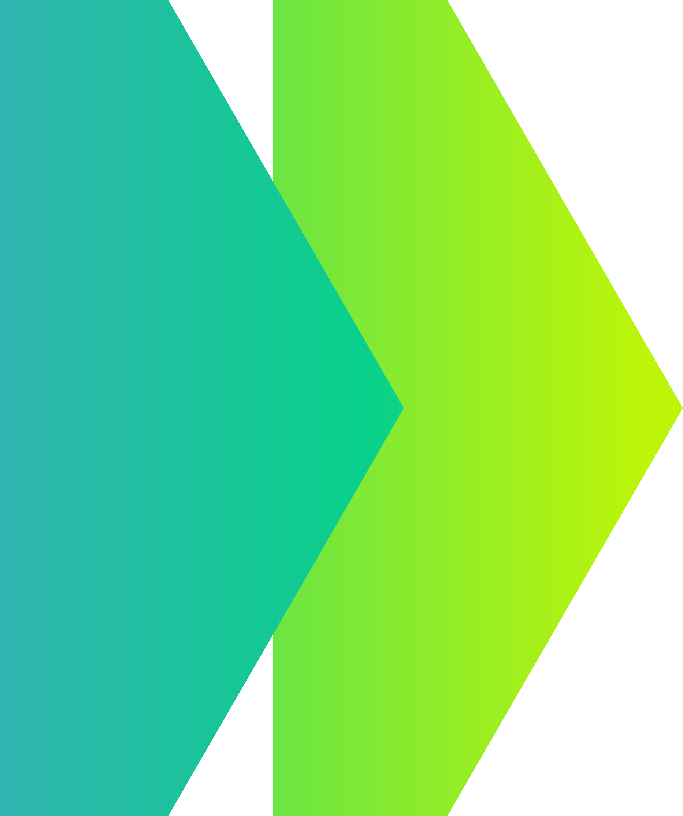

In [ ]:
g.reports(display=True)

### Train-on-Synthetic / Test-on-Real (TSTR) 

Habiendo evaluado que las principales estadísticas del dataset real se preservan en su contraparte sintética, ahora verifiquemos la utilidad del dataset generado en términos de una tarea downstream simple pero realista.

Una forma de verificar si el dataset sintético generado es útil es entrenar un modelo con él y luego evaluarlo en un holdout set real.

# ![TSTR](TSTR.png)


**Pregunta:** Verifiquemos si podemos predecir el estado de supervivencia de los pasajeros desde nuestro dataset sintético.

Tarea: predecir el estado de supervivencia de los pasajeros

*¿Es útil el dataset sintético?*

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler as SkStandardScaler

In [ ]:
# Get training and hold-out sets for the downstream task (we drop Nan for now)

# Synthetic training set
y_syn_train = X_syn.dropna()['survived']
X_syn_train = X_syn.dropna().drop(columns=['survived'])

# Real training set
real_train_clean = X_train.dropna()
y_real_train = real_train_clean['survived']
X_real_train = real_train_clean.drop(columns=['survived'])

# Real test set (we use the hold-out set we prepared earlier)
y_real_test = X_ho.dropna()['survived']
X_real_test = X_ho.dropna().drop(columns=['survived'])

In [ ]:
# Your code here
# ...
# ...
# ...
# ...
# ...
# ...
# ...

In [ ]:
# Solution:

# Create preprocessing pipeline for categorical and numeric features
categorical_features = ['pclass', 'sex', 'embarked'] 
numeric_features = ['age', 'sibsp', 'parch', 'fare']

# Create preprocessing steps
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SkStandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Create full pipeline
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=500))
])

# Fit and predict
clf.fit(X_syn_train, y_syn_train)
y_pred = clf.predict(X_real_test)
print(classification_report(y_real_test, y_pred))
tstr_report = classification_report(y_real_test, y_pred, output_dict=True)


              precision    recall  f1-score   support

           0       0.76      0.90      0.83       122
           1       0.81      0.60      0.68        84

    accuracy                           0.78       206
   macro avg       0.79      0.75      0.76       206
weighted avg       0.78      0.78      0.77       206



### Baseline Train-on-Real / Test-on-Real

Antes de confiar en el flujo de trabajo sintético, mantengamos una referencia: entrena el mismo clasificador en el split de entrenamiento *real* y evalúalo en el hold-out set real. Esto ancla el benchmark que queremos que el setup TSTR se acerque.

In [ ]:
# Rebuild the same preprocessing + model pipeline for a fair comparison
real_preprocessor = ColumnTransformer(
    transformers=[
        ('num', SkStandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

real_clf = Pipeline([
    ('preprocessor', real_preprocessor),
    ('classifier', LogisticRegression(max_iter=500))
])

real_clf.fit(X_real_train, y_real_train)
y_pred_real = real_clf.predict(X_real_test)

print('Train-on-Real / Test-on-Real performance:')
print(classification_report(y_real_test, y_pred_real))
real_clfrep = classification_report(y_real_test, y_pred_real, output_dict=True)

Train-on-Real / Test-on-Real performance:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       122
           1       0.76      0.71      0.74        84

    accuracy                           0.79       206
   macro avg       0.79      0.78      0.78       206
weighted avg       0.79      0.79      0.79       206



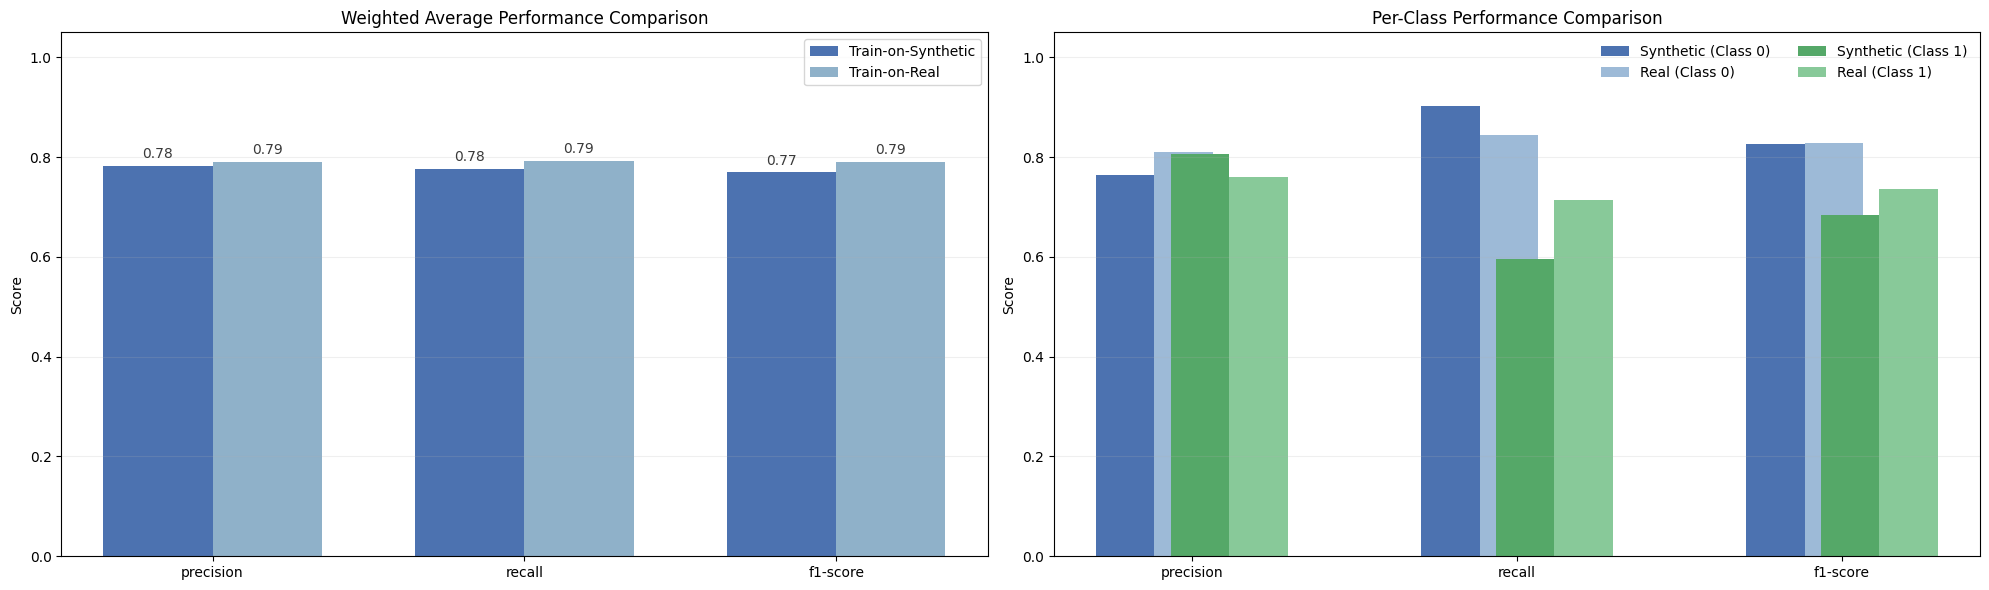

In [21]:
metrics = ['precision', 'recall', 'f1-score']

# Weighted average metrics
tstr_metrics = [tstr_report['weighted avg'][m] for m in metrics]
real_metrics = [real_clfrep['weighted avg'][m] for m in metrics]

# Per class metrics
tstr_metrics_0 = [tstr_report['0'][m] for m in metrics]
tstr_metrics_1 = [tstr_report['1'][m] for m in metrics]
real_metrics_0 = [real_clfrep['0'][m] for m in metrics]
real_metrics_1 = [real_clfrep['1'][m] for m in metrics]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Muted color palette keeps synthetic/real consistent across plots
synthetic_color = '#4C72B0'
real_color = '#8FB1C9'
synthetic_class_colors = ['#4C72B0', '#55A868']
real_class_colors = ['#9DBAD7', '#88C999']

# Plot 1: Weighted average comparison
x = np.arange(len(metrics))
width = 0.35

ax1.bar(x - width / 2, tstr_metrics, width, label='Train-on-Synthetic', color=synthetic_color)
ax1.bar(x + width / 2, real_metrics, width, label='Train-on-Real', color=real_color)

ax1.set_ylabel('Score')
ax1.set_title('Weighted Average Performance Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.set_ylim(0, 1.05)
ax1.legend()
ax1.grid(axis='y', alpha=0.2)

for i, metric in enumerate(metrics):
    ax1.text(i - width / 2, tstr_metrics[i] + 0.01, f'{tstr_metrics[i]:.2f}', ha='center', va='bottom', color='#3A3A3A')
    ax1.text(i + width / 2, real_metrics[i] + 0.01, f'{real_metrics[i]:.2f}', ha='center', va='bottom', color='#3A3A3A')

# Plot 2: Per-class comparison
width = 0.18
gap = 0.05

class0_positions = x - width - gap / 2
class1_positions = x + gap / 2

ax2.bar(class0_positions, tstr_metrics_0, width, label='Synthetic (Class 0)', color=synthetic_class_colors[0])
ax2.bar(class0_positions + width, real_metrics_0, width, label='Real (Class 0)', color=real_class_colors[0])
ax2.bar(class1_positions, tstr_metrics_1, width, label='Synthetic (Class 1)', color=synthetic_class_colors[1])
ax2.bar(class1_positions + width, real_metrics_1, width, label='Real (Class 1)', color=real_class_colors[1])

ax2.set_ylabel('Score')
ax2.set_title('Per-Class Performance Comparison')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics)
ax2.set_ylim(0, 1.05)
ax2.grid(axis='y', alpha=0.2)
ax2.legend(ncol=2, frameon=False)

plt.tight_layout()
plt.show()


### Un adelanto de lo que viene

El dataset de `Titanic` tiene algunos problemas:
- valores faltantes
- categorías subrepresentadas

In [22]:
print("\nMissing values in X_train:")
print(X_train.isnull().sum())
print("\nPercentage of missing values:")
print((X_train.isnull().sum() / len(X_train) * 100).round(2), "%")



Missing values in X_train:
survived      0
pclass        0
sex           0
age         209
sibsp         0
parch         0
fare          1
embarked      0
dtype: int64

Percentage of missing values:
survived     0.00
pclass       0.00
sex          0.00
age         19.96
sibsp        0.00
parch        0.00
fare         0.10
embarked     0.00
dtype: float64 %


In [23]:
X_train.survived.value_counts(normalize=True)

survived
0    0.617956
1    0.382044
Name: proportion, dtype: float64

In [ ]:
# Assess classifier quality separately for each survival class
def _extract_metrics(report, label):
    metrics = pd.DataFrame(report).T.loc[['0', '1'], ['precision', 'recall', 'f1-score', 'support']]
    metrics.index = metrics.index.map({'0': 'Did not survive (0)', '1': 'Survived (1)'})
    metrics.insert(0, 'Model', label)
    return metrics

summary_frames = []
if 'real_clfrep' in globals():
    summary_frames.append(_extract_metrics(real_clfrep, 'Train-on-Real/Test-on-Real'))
if 'tstr_report' in globals():
    summary_frames.append(_extract_metrics(tstr_report, 'TSTR (Baseline synthetic)'))
if not summary_frames:
    raise NameError('No classification reports found. Run the evaluation cells above first.')

quality_summary = pd.concat(summary_frames)
quality_summary = quality_summary.reset_index().rename(columns={'index': 'Survival class'})
quality_summary[['precision', 'recall', 'f1-score']] = quality_summary[['precision', 'recall', 'f1-score']].round(3)
display(quality_summary)


Survival class                       Model  precision  recall  \
0  Did not survive (0)  Train-on-Real/Test-on-Real      0.811   0.844   
1         Survived (1)  Train-on-Real/Test-on-Real      0.759   0.714   
2  Did not survive (0)   TSTR (Baseline synthetic)      0.764   0.902   
3         Survived (1)   TSTR (Baseline synthetic)      0.806   0.595   

   f1-score  support  
0     0.827    122.0  
1     0.736     84.0  
2     0.827    122.0  
3     0.685     84.0

## Coffee break

# ![coffee_break](coffee_break.png)


## 2. Imputation y Rebalancing

Vamos a:
- revisitar el dataset de Titanic y refrescar el generator
- configurar smart imputation durante el muestreo y validar la utilidad downstream (TSTR)
- rebalancear la categoría de supervivencia que tenga peor desempeño para inspeccionar el impacto en el desempeño del modelo

In [25]:
def run_clf(df, label):
    df = df.dropna()
    if df.empty:
        raise ValueError('Synthetic data became empty after dropping NAs; check the configuration.')

    y_trn = df['survived']
    X_trn = df.drop(columns=['survived'])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', SkStandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ]
    )

    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=500))
    ])

    # set seed for reproducibility
    np.random.seed(42)
    clf.fit(X_trn, y_trn)
    y_pred = clf.predict(X_real_test)

    print(f"=== {label} ===")
    print(classification_report(y_real_test, y_pred, digits=3))
    report = classification_report(y_real_test, y_pred, digits=3, output_dict=True)

    return clf, report, y_pred

### 2.1 Smart Imputation Durante la Generación

Comenzamos instruyendo al generator para imputar los valores faltantes de `age` y `fare` cuando muestreamos. Esto mantiene todos los registros downstream utilizables sin descartar filas.

In [26]:
print('Missing values in training data (selected columns):')
print(X_train[['age', 'fare']].isnull().sum())


Missing values in training data (selected columns):
age     209
fare      1
dtype: int64


In [27]:
df_seed = X_train[X_train['age'].isnull()].drop(columns=['age'])
df_seed.head(3)

survived  pclass     sex  sibsp  parch  fare embarked
999          1       3  female      0      0   8.0        Q
196          1       1    male      0      0  30.0        C
1292         0       3    male      0      0   8.0        S

In [28]:
df_seed.shape

(209, 7)

Combinamos seeded generation -- es decir, proporcionamos al generator un dataset inicial con columnas fijas para que lo "complete" -- e imputation para adivinar los valores faltantes de `age`.

In [29]:
imputation_config = {
    'name': 'Titanic Imputation Demo',
    'tables': [
        {
            'name': 'titanic',
            'configuration': {
                'imputation': {
                    'columns': ['age']
                }
            }
        }
    ],
}

sd_imputed = mostly.generate(generator=g, config=imputation_config, seed=df_seed)
syn_imputed = sd_imputed.data()

print('Remaining missing values in synthetic sample (selected columns):')
print(syn_imputed[['age']].isnull().sum())

Created synthetic dataset adc947b9-96a6-4a93-afff-8b5de5d83360 with generator db8fcf16-3896-41b7-a48f-3e7b526ab146

Started synthetic dataset generation

Output()

🎉 Your synthetic dataset is ready! Use it to consume the generated data. Publish it so others can do the same.

Remaining missing values in synthetic sample (selected columns):
age    0
dtype: int64


In [30]:
syn_imputed.head(3)

survived  pclass     sex  age  sibsp  parch  fare embarked
0         1       3  female   18      0      0   8.0        Q
1         1       1    male   42      0      0  30.0        C
2         0       3    male   28      0      0   8.0        S

In [ ]:
# Drop rows with null age from X_train and append synthetic imputed data
X_train_simp = X_train.copy()
X_train_simp = X_train_simp[~X_train_simp['age'].isnull()]
X_train_simp = pd.concat([X_train_simp, syn_imputed], axis=0)

In [32]:
print('Missing values in training data (selected columns):')
print(X_train_simp[['age', 'fare']].isnull().sum())

Missing values in training data (selected columns):
age     0
fare    1
dtype: int64


In [ ]:
# There's only one row with a missing value, let's drop it:
X_train_simp = X_train_simp.dropna()

In [34]:
clf_imputed, report_imputed, _ = run_clf(X_train_simp, label='TSTR with imputation-enabled synthetic data')

=== TSTR with imputation-enabled synthetic data ===
              precision    recall  f1-score   support

           0      0.822     0.869     0.845       122
           1      0.792     0.726     0.758        84

    accuracy                          0.811       206
   macro avg      0.807     0.798     0.801       206
weighted avg      0.810     0.811     0.809       206



¿Qué hay de un mecanismo de imputation más directo pero ingenuo?

In [ ]:
# Implement naive imputation for comparison
X_train_naive = X_train.copy()

X_train_naive['age'] = X_train_naive['age'].fillna(X_train_naive['age'].mean())

# For categorical columns, use mode imputation
X_train_naive['embarked'] = X_train_naive['embarked'].fillna(X_train_naive['embarked'].mode()[0])

# Run TSTR evaluation with naive imputation
clf_naive, report_naive, _ = run_clf(X_train_naive, label='TSTR with naive imputation')


=== TSTR with naive imputation ===
              precision    recall  f1-score   support

           0      0.819     0.852     0.835       122
           1      0.772     0.726     0.748        84

    accuracy                          0.801       206
   macro avg      0.796     0.789     0.792       206
weighted avg      0.800     0.801     0.800       206



Una comparación visual entre métodos:

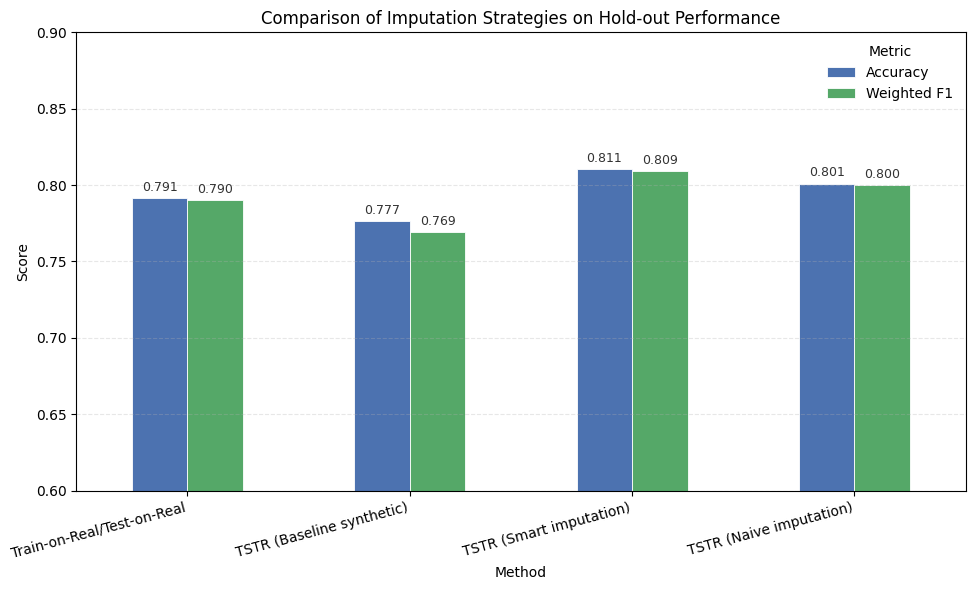

In [ ]:
# Prepare comparison data for different imputation strategies
required_vars = {
    'report_imputed': 'Run the imputation-enabled TSTR cell first.',
    'report_naive': 'Run the naive imputation TSTR cell first.',
    'real_clfrep': 'Run the Train-on-Real / Test-on-Real baseline cell first.'
}

for var, msg in required_vars.items():
    if var not in globals():
        raise NameError(msg)

records = [
    ('Train-on-Real/Test-on-Real', 'Accuracy', real_clfrep['accuracy']),
    ('Train-on-Real/Test-on-Real', 'Weighted F1', real_clfrep['weighted avg']['f1-score']),
    ('TSTR (Smart imputation)', 'Accuracy', report_imputed['accuracy']),
    ('TSTR (Smart imputation)', 'Weighted F1', report_imputed['weighted avg']['f1-score']),
    ('TSTR (Naive imputation)', 'Accuracy', report_naive['accuracy']),
    ('TSTR (Naive imputation)', 'Weighted F1', report_naive['weighted avg']['f1-score']),
]

if 'tstr_report' in globals():
    records.extend([
        ('TSTR (Baseline synthetic)', 'Accuracy', tstr_report['accuracy']),
        ('TSTR (Baseline synthetic)', 'Weighted F1', tstr_report['weighted avg']['f1-score']),
    ])

comparison_df = pd.DataFrame(records, columns=['Method', 'Metric', 'Score'])
comparison_df['Method'] = pd.Categorical(
    comparison_df['Method'],
    categories=[
        'Train-on-Real/Test-on-Real',
        'TSTR (Baseline synthetic)',
        'TSTR (Smart imputation)',
        'TSTR (Naive imputation)'
    ],
    ordered=True
)
comparison_df = comparison_df.dropna(subset=['Method'])
pivot_df = comparison_df.pivot(index='Method', columns='Metric', values='Score').sort_index()

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#4C72B0', '#55A868']
pivot_df.plot(kind='bar', ax=ax, color=colors, edgecolor='white', linewidth=0.6)

ax.set_title('Comparison of Imputation Strategies on Hold-out Performance')
ax.set_ylabel('Score')
ax.set_xlabel('Method')
ax.set_ylim(0.6, 0.9)
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.legend(title='Metric', frameon=False)
plt.xticks(rotation=15, ha='right')

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=9, color='#333333')

plt.tight_layout()
plt.show()


**Pregunta:** Enmascara valores en otras columnas, imputa y compara el desempeño versus simplemente eliminar los valores faltantes. Tal vez incluso ver cómo evoluciona el desempeño para proporciones más grandes de valores faltantes/imputados.

In [ ]:
def mask_random_values(df, mask_prob=0.1):
    """
    Mask out random values in the DataFrame with a specified probability.
    """
    pass

### 2.2 Rebalancing de Resultados de Supervivencia

Para entender cómo el balanceo del target downstream impacta la utilidad, llevaremos el split de entrenamiento sintético a una mezcla 50/50 de sobrevivientes y no sobrevivientes, reejecutaremos la evaluación TSTR, e inspeccionaremos cómo responde cada clase.

In [ ]:
# Survival distribution in the synthetic training data
X_train_base = X_train.copy().dropna()
survival_counts = X_train_base['survived'].value_counts().sort_index()
survival_share = survival_counts / len(X_train_base)
display(pd.DataFrame({
    'count': survival_counts,
    'share_pct': (survival_share * 100).round(2)
}))


count  share_pct
survived                  
0           496      59.26
1           341      40.74

In [39]:
survival_counts = X_train_base['survived'].value_counts().sort_index()
non_survivors = survival_counts.get(0, 0)
survivors = survival_counts.get(1, 0)
additional_survivors = max(non_survivors - survivors, 0)
print(f'Current survivors: {survivors}, non-survivors: {non_survivors}')
print(f'Additional survived=1 rows needed: {additional_survivors}')
if additional_survivors > 0:
    survivors_pool = X_syn.dropna()
    survivors_pool = survivors_pool[survivors_pool['survived'] == 1]
    if survivors_pool.empty:
        raise ValueError('No survived=1 rows available to upsample from.')
    extra_survivors = survivors_pool.sample(additional_survivors, replace=True, random_state=42)
    X_train_balanced = pd.concat([X_train_base, extra_survivors], ignore_index=True)
else:
    X_train_balanced = X_train_base.copy()

balanced_counts = X_train_balanced['survived'].value_counts().sort_index()
display(pd.DataFrame({
    'count': balanced_counts,
    'share_pct': (balanced_counts / len(X_train_balanced) * 100).round(2)
}))


Current survivors: 341, non-survivors: 496
Additional survived=1 rows needed: 155


count  share_pct
survived                  
0           496       50.0
1           496       50.0

In [ ]:
# Re-run TSTR on the survival-balanced synthetic dataset
clf_balanced, report_balanced, y_pred_balanced = run_clf(X_train_balanced, label='TSTR with survival-balanced synthetic data')

=== TSTR with survival-balanced synthetic data ===
              precision    recall  f1-score   support

           0      0.829     0.795     0.812       122
           1      0.719     0.762     0.740        84

    accuracy                          0.782       206
   macro avg      0.774     0.778     0.776       206
weighted avg      0.784     0.782     0.782       206



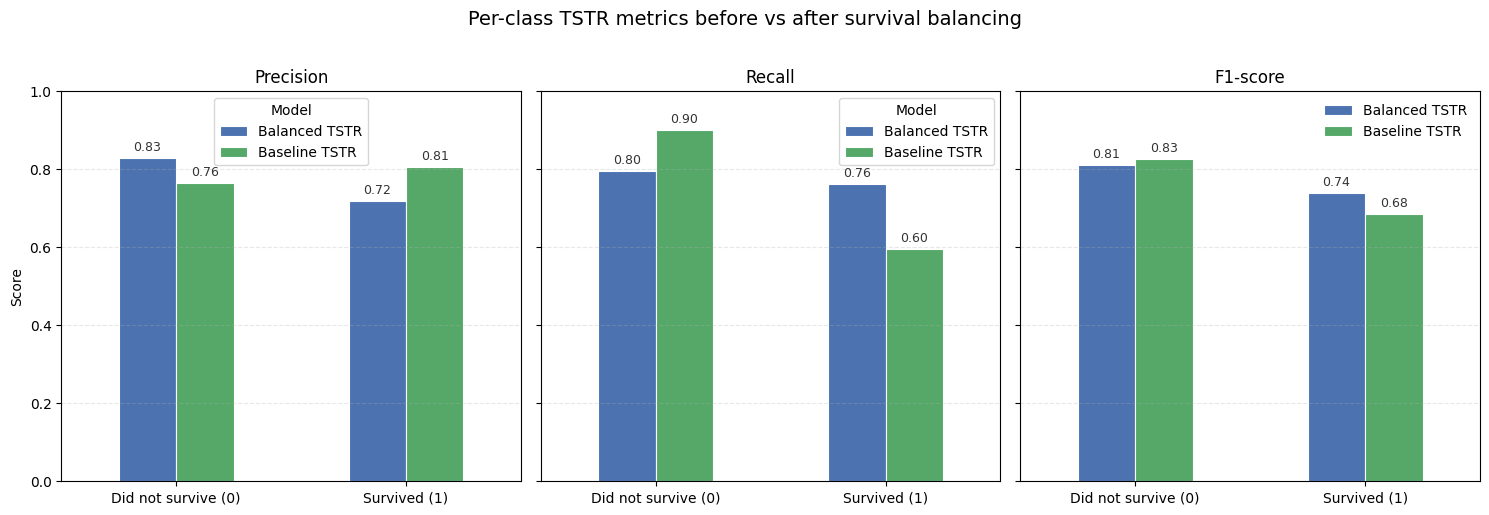

In [ ]:
# Compare per-class performance before and after balancing
def _class_metrics(report, label):
    df = pd.DataFrame(report).T.loc[['0', '1'], ['precision', 'recall', 'f1-score']]
    df = df.rename(index={'0': 'Did not survive (0)', '1': 'Survived (1)'})
    df = df.reset_index().rename(columns={'index': 'Survival class'})
    df['Model'] = label
    return df

comparisons = []
comparisons.append(_class_metrics(tstr_report, 'Baseline TSTR'))
comparisons.append(_class_metrics(report_balanced, 'Balanced TSTR'))
metrics_df = pd.concat(comparisons, ignore_index=True)
metric_order = ['precision', 'recall', 'f1-score']
metrics_df = metrics_df.melt(id_vars=['Survival class', 'Model'], value_vars=metric_order, var_name='Metric', value_name='Score')
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
colors = ['#4C72B0', '#55A868']
for ax, metric in zip(axes, metric_order):
    pivot = metrics_df[metrics_df['Metric'] == metric].pivot(index='Survival class', columns='Model', values='Score')
    pivot.plot(kind='bar', ax=ax, color=colors, edgecolor='white', linewidth=0.8)
    ax.set_title(metric.capitalize())
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3, fontsize=9, color='#333333')
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
axes[0].set_ylabel('Score')
axes[-1].legend(frameon=False)
plt.suptitle('Per-class TSTR metrics before vs after survival balancing', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


## [Muy abierto] ¡Mini-desafío!

Tomemos media hora para intentar mejorar sobre el baseline clásico Train-Real/Test-Real. ¡En realidad hay una [competencia de kaggle](https://www.kaggle.com/competitions/titanic) sobre predicción del estado de supervivencia para `Titanic`! Si te sientes inspirado, tal vez puedas obtener los datos, entrenar un modelo aprovechando datos sintéticos, y hacer una submission.

Algunos puntos:
- tal vez hagas imputation de valores faltantes en el training set
- tal vez combines imputation y rebalancing
- tal vez hagas algún tipo de post-processing a los datos sintéticos antes de entrenar el clasificador
- o juegues con los tipos de encoding de las columnas

¡Diviértete!